# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!unzip -q "/content/drive/MyDrive/isic-2019.zip" #https://www.kaggle.com/datasets/andrewmvd/isic-2019

Mounted at /content/drive


In [ ]:
import os
#os.system('pip install .')
os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')
os.system('pip install git+https://github.com/hamish-haggerty/cancer-proj.git')
!pip install -qU git+https://github.com/hamish-haggerty/cancer-proj.git #sometimes os doesn't work so use this if imports below fail

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
from fastai.vision.all import *
from base_rbt.all import *
#TODO: wrap this in an .all
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module
from statistics import mean,stdev

import fastai
test_eq(fastai.__version__,'2.7.11')

import torch
test_eq(torch.__version__,'1.13.1+cu116')


#Get data paths:

In [ ]:
save_directory = '/content/drive/My Drive/cancer_colab' #directory for saving models etc
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [ ]:
directory = "/content/drive/MyDrive/ISIC_2019_Training_Input/"
data = pd.read_csv("/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
data = data[~data["image"].str.contains("downsampled")]
labels = pd.read_csv("/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv")

data_dict = load_dict_from_gdrive(directory=save_directory,filename='data_dict') 
_fnames = data_dict['_fnames']
#_fnames = get_image_files(directory) 
#_fnames = [name for name in _fnames if 'downsampled' not in name.as_posix()] #otherwise load like this
test_eq(len(_fnames),len(data))

label_func_dict = data_dict['label_func_dict']

def label_func(name):
    return label_func_dict[name]
_labels = [label_func(i) for i in _fnames]

# Build training, tuning, validation test sets:
    - Training is unlabelled
    - Tuning is for supervised fine tuning
    - Validation is a held out (proxy) test set
    - Test set is for getting results

In [ ]:
#tests / sanity checks:
test_eq(process_path(_fnames[0]),'ISIC_0071718.jpg')
test_eq(process_path(_fnames[10]),'ISIC_0071719.jpg')

_fnames_dict = get_fnames(_fnames,_labels,label_func)
fnames_train,fnames_valid,fnames_test = _fnames_dict['fnames_train'],_fnames_dict['fnames_valid'],_fnames_dict['fnames_test'] 
labels_train,labels_valid,labels_test = _fnames_dict['labels_train'],_fnames_dict['labels_valid'],_fnames_dict['labels_test'] 

print(f'Training (tuning) set has: \n{Counter(labels_train)}\n')

print(f'Validation set has: \n{Counter(labels_valid)}\n')

print(f'Test set has: \n{Counter(labels_test)}\n')

#A few tests: Make sure fnames_train and fnames_test the same every time
test_eq(process_path(fnames_train[44]),'ISIC_0071754.jpg')
test_eq(process_path(fnames_test[10]),'ISIC_0000011.jpg')

#Make sure training and valid are disjoint
for path in fnames_valid: assert path not in fnames_train #check that valid set is disjoint from training (tuning) set

#Make sure test and valid+train are disjoint
for path in fnames_test: assert path not in fnames_train+fnames_valid #check that test set is disticnt from training and validation set

Training (tuning) set has: 
Counter({'NV': 500, 'MEL': 500, 'BCC': 500, 'BKL': 467, 'AK': 306, 'SCC': 171, 'VASC': 55, 'DF': 55})

Validation set has: 
Counter({'NV': 458, 'MEL': 309, 'BCC': 274, 'BKL': 110, 'AK': 63, 'SCC': 43, 'VASC': 12, 'DF': 11})

Test set has: 
Counter({'NV': 10601, 'MEL': 3339, 'BCC': 2549, 'BKL': 1663, 'AK': 498, 'SCC': 414, 'VASC': 186, 'DF': 173})



# Setup dataloaders

In [ ]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

size=256
item_tfms = [Resize(size)]

item_tfms_train = [Resize(128)]

dls_tune  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_valid  = ImageDataLoaders.from_path_func(directory, fnames_valid, label_func,
                                bs=256,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )

#This is for training BT (so viewed as unlabelled)
dls_train  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=128,
                                item_tfms=item_tfms_train,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_test =  ImageDataLoaders.from_path_func(directory, fnames_test, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda'),
                                shuffle=False
                                )

classes_to_int={v:i for i,v in enumerate(dls_tune.vocab)}
int_to_classes = {i: v for i, v in enumerate(dls_tune.vocab)}
vocab=dls_tune.vocab

# Aug pipelines

In [ ]:
aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines'] #Heavy augmentation. Use to train BT
aug_pipelines_tune = aug_dict['aug_pipelines_tune'] #Used for fine tuning
aug_pipelines_test = aug_dict['aug_pipelines_test'] #Test time augmentation (generally same as above)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


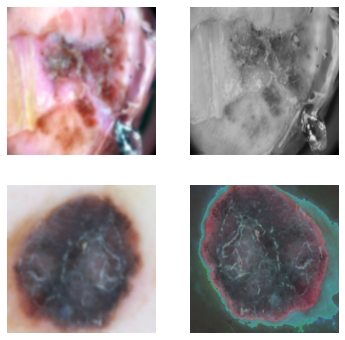

In [ ]:
show_bt_batch(dls_train,n_in=3,n=2,aug=aug_pipelines)

# Fine tune supervised model, get test set performance:

In [ ]:
#Hyperparams: description, type of intial weights, number of epochs, number of runs

#In this block we set the hps for the run. Then we call `main_tune` with these values
#########
description = 'Sup initial weights, 40 epochs'
initial_weights='supervised_pretrain'
epochs=40
runs=range(35) #we have already saved results for runs 0,1,2

tune_model_path = save_directory + f'/initial_weights={initial_weights}' 
dict_path = f'{initial_weights}' #file to load dictionary metadata

#_results=load_dict_from_gdrive(save_directory,'supervised_pretrain')
_results=None
#########

#fine tune 
sup_results = main_tune(initial_weights=initial_weights,epochs=epochs,device=device,dls_tune=dls_tune,dls_test=dls_test,
                        aug_pipelines_tune=aug_pipelines_tune,aug_pipelines_test=aug_pipelines_tune,int_to_classes=int_to_classes,
                        tune_model_path=tune_model_path, dict_path = dict_path,save_directory=save_directory,description=description,
                        results=_results,runs=runs,
                        )

# As above but for BT initial weights:

In [ ]:
#In this block we set the hps for the run. Then we call `main_tune` with these values
######### 
description = 'BT initial weights, 40 epochs'
initial_weights='bt_pretrain'
epochs=40
runs=range(35) #we have already saved results for runs 0,1,2

tune_model_path = save_directory + f'/initial_weights={initial_weights}' 
dict_path = f'{initial_weights}' #file to load dictionary metadata

#_results=load_dict_from_gdrive(save_directory,'supervised_pretrain')
_results=None
#########

#fine tune 
bt_results = main_tune(initial_weights=initial_weights,epochs=epochs,device=device,dls_tune=dls_tune,dls_test=dls_test,
                        aug_pipelines_tune=aug_pipelines_tune,aug_pipelines_test=aug_pipelines_tune,int_to_classes=int_to_classes,
                        tune_model_path=tune_model_path, dict_path = dict_path,save_directory=save_directory,description=description,
                        results=_results,runs=runs,
                        )

Verify loading and check results:

In [ ]:
sup_results = load_dict_from_gdrive(save_directory,'supervised_pretrain')

In [ ]:
lst=[sup_results[i]['acc'] for i in range(35)]
print(sup_results.keys())
print(mean(lst))
print(stdev(lst))

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])
0.6628415499414716
0.019809059709962048


In [ ]:
bt_results = load_dict_from_gdrive(save_directory,'bt_pretrain')
print(bt_results.keys())
lst=[bt_results[i]['acc'] for i in range(35)]
print(mean(lst))
print(stdev(lst))

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])
0.7030501416751317
0.014212303705937417


# Mean classification report for supervised weights:

In [ ]:
#sup_results=load_dict_from_gdrive(save_directory,'sup_results') #how to load

mean_sup_results = Mean_Results(sup_results,vocab)

              precision    recall  f1-score   support

          AK       0.36      0.57      0.44     498.0
         BCC       0.70      0.76      0.72    2549.0
         BKL       0.47      0.49      0.48    1663.0
          DF       0.37      0.30      0.33     173.0
         MEL       0.50      0.63      0.56    3339.0
          NV       0.85      0.70      0.77   10601.0
         SCC       0.36      0.34      0.35     414.0
        VASC       0.25      0.67      0.35     186.0

    accuracy                           0.66   19423.0
   macro avg       0.48      0.56      0.50   19423.0
weighted avg       0.70      0.66      0.68   19423.0

mean acc is 0.6628415499414716 with std 0.019809059709962048


# Mean classification report for self-supervised weights:

In [ ]:
#bt_results=load_dict_from_gdrive(save_directory,'bt_results') #how to load 
mean_bt_results = Mean_Results(bt_results,vocab)

              precision    recall  f1-score   support

          AK       0.37      0.57      0.45     498.0
         BCC       0.70      0.75      0.73    2549.0
         BKL       0.49      0.50      0.49    1663.0
          DF       0.43      0.32      0.37     173.0
         MEL       0.52      0.63      0.57    3339.0
          NV       0.86      0.78      0.82   10601.0
         SCC       0.48      0.34      0.39     414.0
        VASC       0.53      0.51      0.51     186.0

    accuracy                           0.70   19423.0
   macro avg       0.55      0.55      0.54   19423.0
weighted avg       0.72      0.70      0.71   19423.0

mean acc is 0.7030501416751317 with std 0.014212303705937417
